# Online Gaming Behavior Analysis & Prediction

## Overview
This notebook explores the **Online Gaming Behavior Dataset**, which captures demographic and behavioral attributes of players across different game genres. The goal is to analyze gaming patterns, understand factors influencing engagement, and build predictive models for **player engagement levels** (`High`, `Medium`, `Low`).

This analysis is conducted on **Databricks**, leveraging its scalable data processing and collaborative analytics environment. **MLflow** is used for experiment tracking, model versioning, and performance comparison throughout the modeling process.

---

## Dataset Description
**Source:** [Kaggle – Predict Online Gaming Behavior Dataset](https://www.kaggle.com/datasets/rabieelkharoua/predict-online-gaming-behavior-dataset)

**Dataset Features:**

| Feature | Description |
|----------|-------------|
| `PlayerID` | Unique identifier for each player |
| `Age` | Age of the player |
| `Gender` | Gender of the player |
| `Location` | Geographic location of the player |
| `GameGenre` | Genre of the game the player plays |
| `PlayTimeHours` | Average hours spent per session |
| `InGamePurchases` | Whether the player makes in-game purchases (0 = No, 1 = Yes) |
| `GameDifficulty` | Difficulty level of the game |
| `SessionsPerWeek` | Number of gaming sessions per week |
| `AvgSessionDurationMinutes` | Average duration of each session (minutes) |
| `PlayerLevel` | Current level of the player |
| `AchievementsUnlocked` | Total achievements unlocked |
| `EngagementLevel` | Player engagement level (`High`, `Medium`, `Low`) – **target variable** |

---

## Objectives
1. **Data Exploration & Cleaning**
   - Handle missing values, outliers, and inconsistent data.
   - Explore feature distributions and correlations.

2. **Exploratory Data Analysis**
   - Analyze player demographics and behavior trends.
   - Visualize patterns in engagement across age, gender, game genre, and playtime.

3. **Feature Engineering**
   - Encode categorical variables.
   - Scale or normalize numerical features.


4. **Model Building & Evaluation**
   - Train the **XGBoost** classifier using **Grid Search** for hyperparameter tuning.
   - Predict **EngagementLevel**.
   - Track experiments and metrics using **MLflow**.
   - Evaluate performance using accuracy, F1-score, and confusion matrix.

5. **Insights & Recommendations**
   - Identify the key drivers of high engagement.
   - Provide actionable insights for improving player retention.
   - Suggest actions to attract more high engagement players and expand into the weaker regions.

---

## Notebook Structure
1. Data Overview & Preprocessing  
2. Exploratory Data Analysis 
3. Feature Engineering  
4. Model Training & Evaluation (with MLflow tracking)  
5. Insights, Conclusions and Suggestions

---

> **Author:** Konstantinos Christogeorgos  
> **Date:** July 2025  
> **Environment:** Databricks with MLflow integration


# 1. Data Overview & Preprocessing  

In [0]:
import pandas as pd

In [0]:
df = pd.read_csv("/Volumes/workspace/default/data/online_gaming_behavior_dataset.csv")

In [0]:
df

,PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
0,9000,43,Male,Other,Strategy,16.271119,0,Medium,6,108,79,25,Medium
1,9001,29,Female,USA,Strategy,5.525961,0,Medium,5,144,11,10,Medium
2,9002,22,Female,USA,Sports,8.223755,0,Easy,16,142,35,41,High
3,9003,35,Male,USA,Action,5.265351,1,Easy,9,85,57,47,Medium
4,9004,33,Male,Europe,Action,15.531945,0,Medium,2,131,95,37,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40029,49029,32,Male,USA,Strategy,20.619662,0,Easy,4,75,85,14,Medium
40030,49030,44,Female,Other,Simulation,13.539280,0,Hard,19,114,71,27,High
40031,49031,15,Female,USA,RPG,0.240057,1,Easy,10,176,29,1,High
40032,49032,34,Male,USA,Sports,14.017818,1,Medium,3,128,70,10,Medium


#2. Exploratory Data Analysis

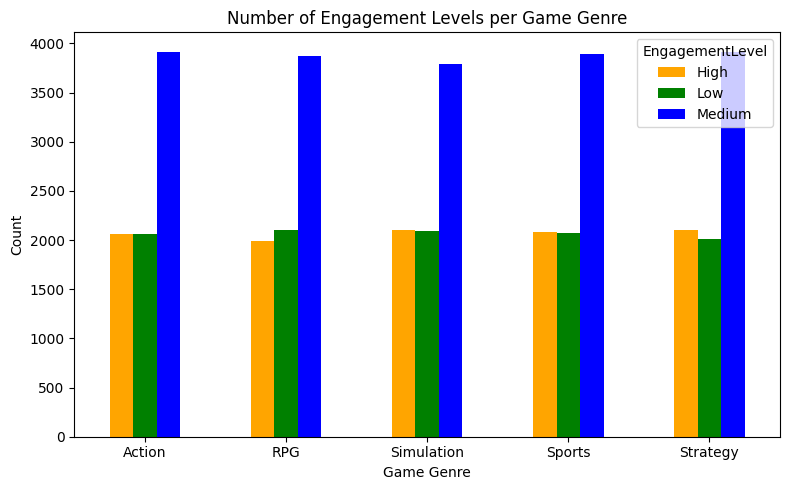

In [0]:
import matplotlib.pyplot as plt

colors = {
    'High': 'orange',
    'Medium': 'blue',
    'Low': 'green'
}

counts = df.groupby(['GameGenre', 'EngagementLevel']).size().unstack(fill_value=0)

ax = counts.plot(
    kind='bar',
    color=[colors[col] for col in counts.columns],
    figsize=(8, 5)
)

plt.title('Number of Engagement Levels per Game Genre')
plt.xlabel('Game Genre')
plt.ylabel('Count')
plt.legend(title='EngagementLevel')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## We can see that engagement level is the same throughout all the game gernes.

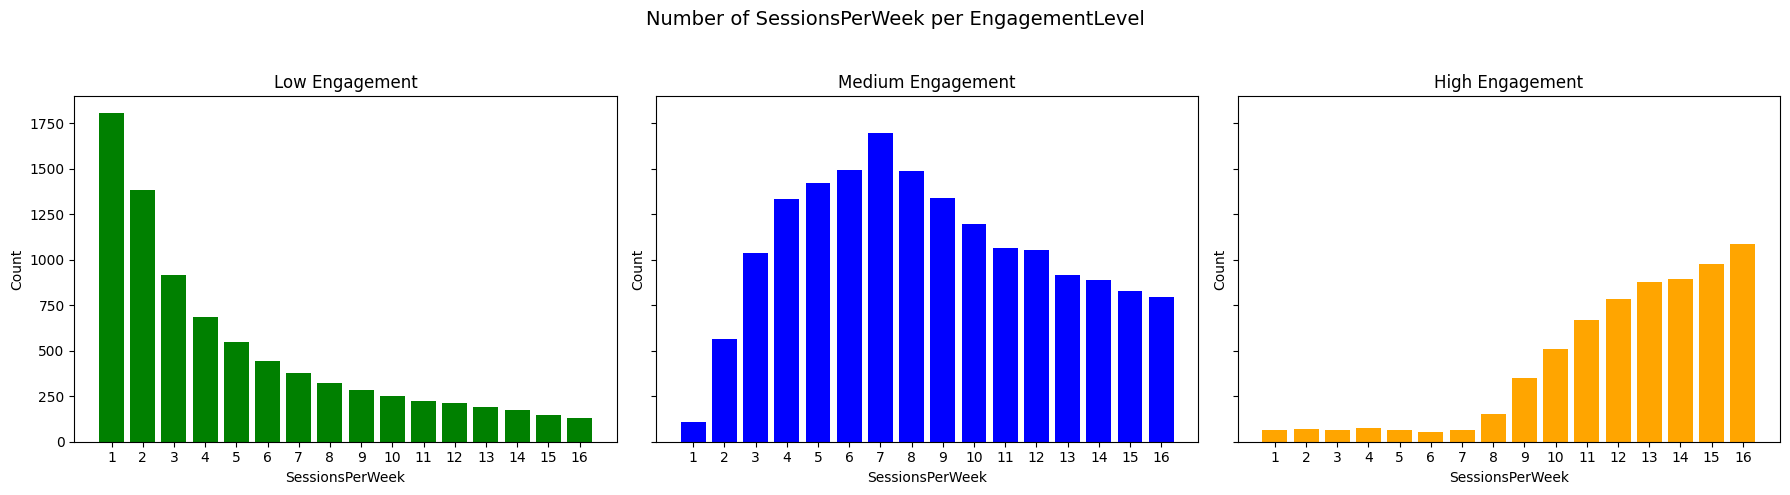

In [0]:
import matplotlib.pyplot as plt

level_order = ['Low', 'Medium', 'High']
colors = {'High': 'orange', 'Medium': 'blue', 'Low': 'green'}

counts = df.groupby(['SessionsPerWeek', 'EngagementLevel']).size().unstack(fill_value=0)
all_weeks = range(1, 17)
counts = counts.reindex(all_weeks, fill_value=0)

counts = counts[level_order]

fig, axes = plt.subplots(nrows=1, ncols=len(level_order), figsize=(18, 5), sharey=True)

for ax, level in zip(axes, level_order):
    ax.bar(counts.index, counts[level], color=colors[level])
    ax.set_title(f'{level} Engagement')
    ax.set_xlabel('SessionsPerWeek')
    ax.set_ylabel('Count')
    ax.set_xticks(counts.index)
    ax.set_xticklabels(counts.index, rotation=0)

fig.suptitle('Number of SessionsPerWeek per EngagementLevel', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## We can clearly observe that the higher the sessions per week the higher the engagement.

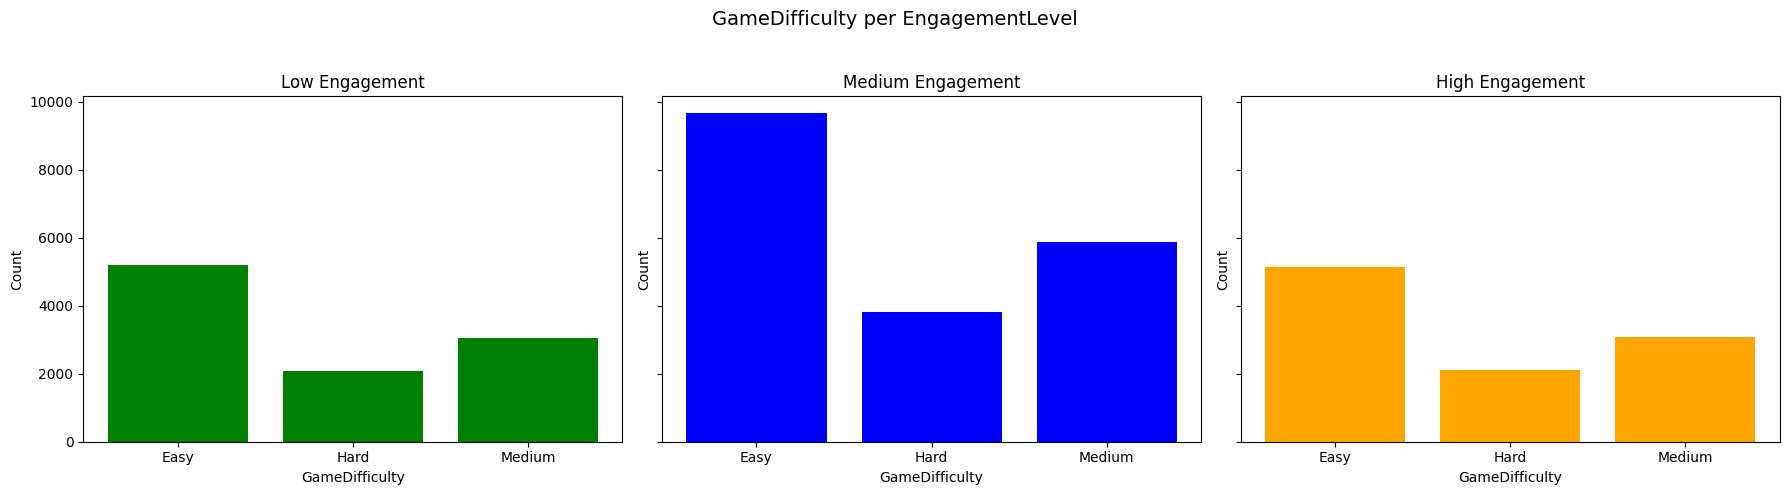

In [0]:
import matplotlib.pyplot as plt

level_order = ['Low', 'Medium', 'High']
colors = {'High': 'orange', 'Medium': 'blue', 'Low': 'green'}

counts = df.groupby(['GameDifficulty', 'EngagementLevel']).size().unstack(fill_value=0)

counts = counts[level_order]

fig, axes = plt.subplots(nrows=1, ncols=len(level_order), figsize=(18, 5), sharey=True)

for ax, level in zip(axes, level_order):
    ax.bar(counts.index, counts[level], color=colors[level])
    ax.set_title(f'{level} Engagement')
    ax.set_xlabel('GameDifficulty')
    ax.set_ylabel('Count')
    ax.set_xticks(counts.index)
    ax.set_xticklabels(counts.index, rotation=0)

fig.suptitle('GameDifficulty per EngagementLevel', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


%md
## Engagement has a similar distribution for each GameDifficulty, with easy being the most played difficulty for each engagement category.

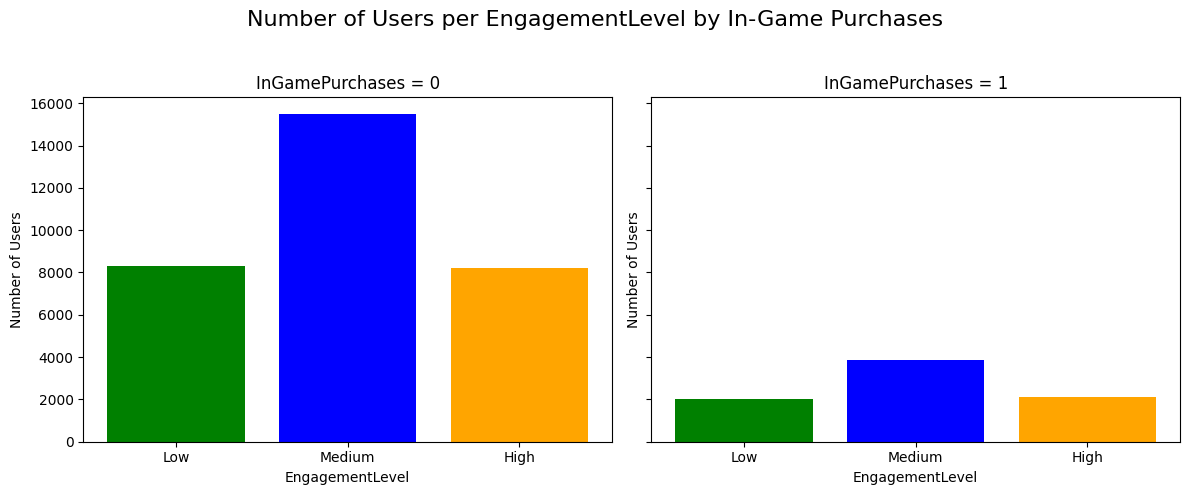

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), sharey=True)

for ax, purchase_value in zip(axes, [0, 1]):
    subset = df[df['InGamePurchases'] == purchase_value]
    counts = subset['EngagementLevel'].value_counts().reindex(level_order, fill_value=0)

    ax.bar(counts.index, counts.values, color=[colors[level] for level in counts.index])
    ax.set_title(f'InGamePurchases = {purchase_value}')
    ax.set_xlabel('EngagementLevel')
    ax.set_ylabel('Number of Users')

fig.suptitle('Number of Users per EngagementLevel by In-Game Purchases', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## We observe the same distribution for the engagement level even if the player has made a purchase.

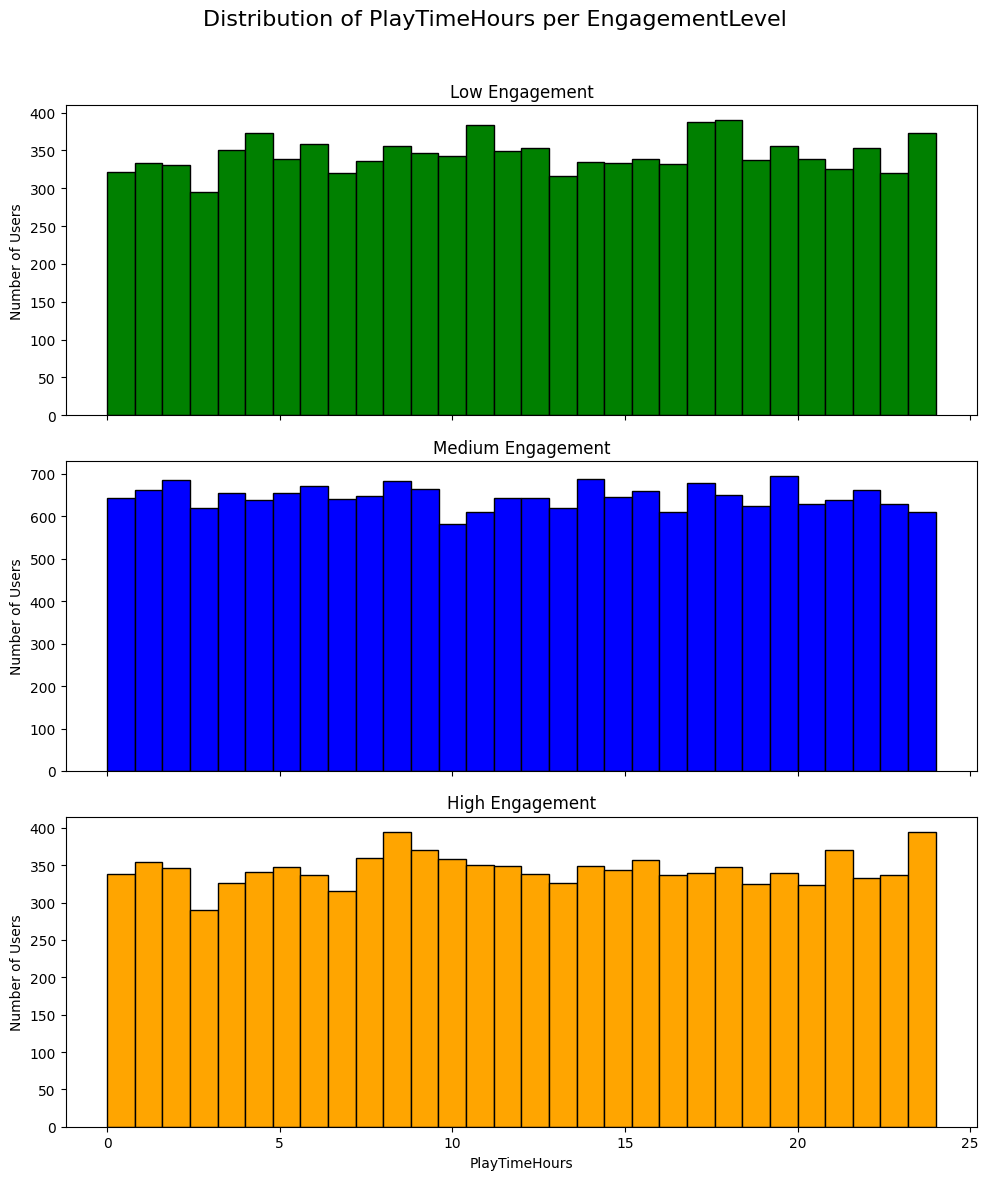

In [0]:
import matplotlib.pyplot as plt

level_order = ['Low', 'Medium', 'High']
colors = {'Low':'green','Medium':'blue','High':'orange'}

fig, axes = plt.subplots(nrows=len(level_order), ncols=1, figsize=(10,12), sharex=True, sharey=False)

for ax, level in zip(axes, level_order):
    subset = df[df['EngagementLevel'] == level]
    ax.hist(subset['PlayTimeHours'], bins=30, color=colors[level], edgecolor='black')
    ax.set_title(f'{level} Engagement')
    ax.set_ylabel('Number of Users')

axes[-1].set_xlabel('PlayTimeHours')
fig.suptitle('Distribution of PlayTimeHours per EngagementLevel', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## Hours played are significantly higher for the Medium engagement, while the hours for Low and High engagement are similar.  

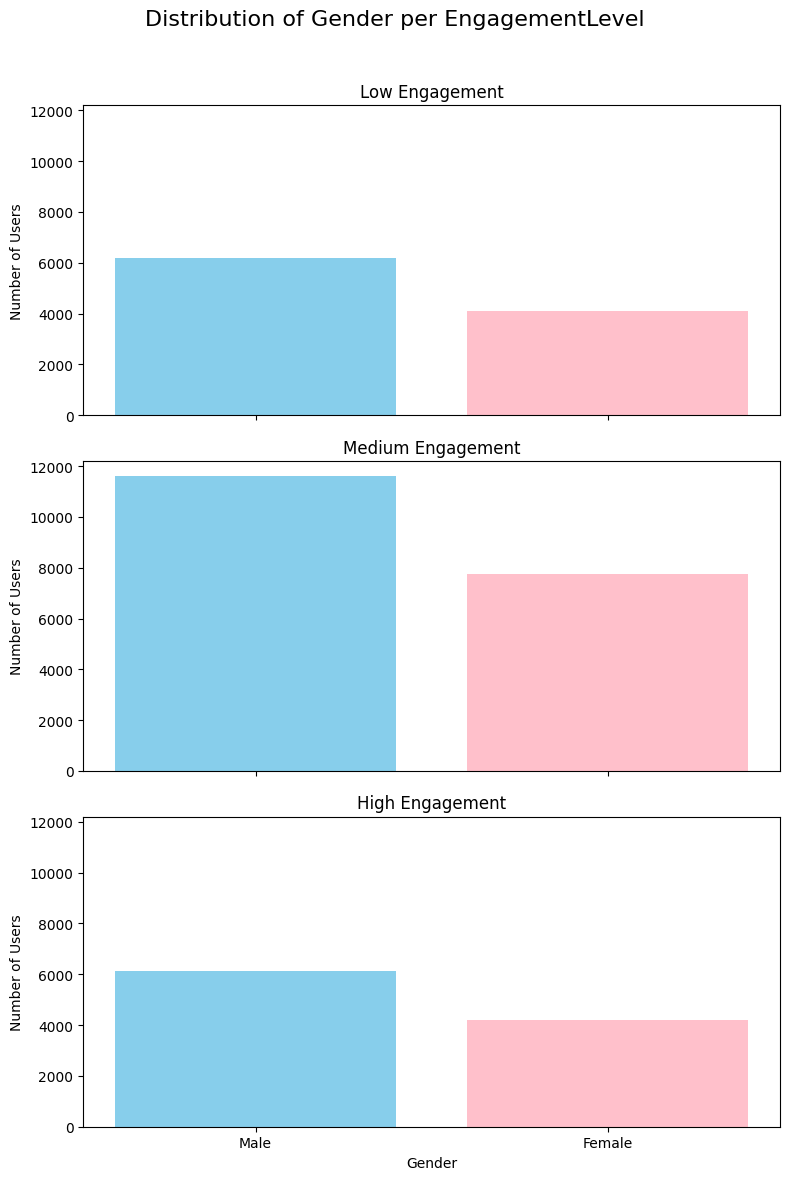

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
colors = {'Male': 'skyblue', 'Female': 'pink'}
level_order = ['Low', 'Medium', 'High']

fig, axes = plt.subplots(nrows=len(level_order), ncols=1, figsize=(8, 12), sharex=True, sharey=True)

for ax, level in zip(axes, level_order):
    subset = df[df['EngagementLevel'] == level]
    counts = subset['Gender'].value_counts()
    ax.bar(counts.index, counts.values, color=[colors.get(g) for g in counts.index])
    ax.set_title(f'{level} Engagement')
    ax.set_ylabel('Number of Users')


axes[-1].set_xlabel('Gender')

fig.suptitle('Distribution of Gender per EngagementLevel', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## It's clear that in all engagement levels the men are are significantly more than the women.

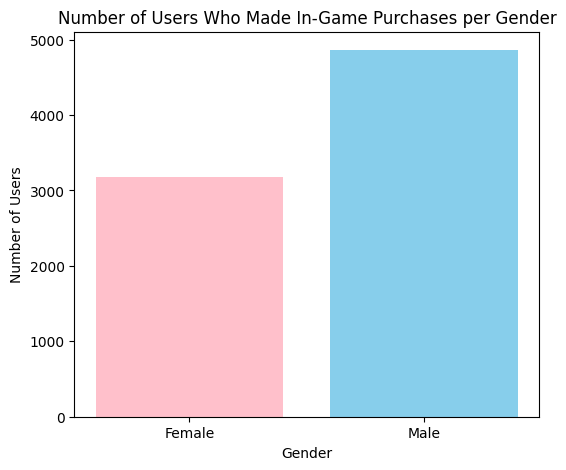

In [0]:

counts = df.groupby(['Gender', 'InGamePurchases']).size().unstack(fill_value=0)
purchase_counts = counts[1]

plt.figure(figsize=(6,5))
plt.bar(purchase_counts.index, purchase_counts.values, color=['pink','skyblue'])
plt.xlabel('Gender')
plt.ylabel('Number of Users')
plt.title('Number of Users Who Made In-Game Purchases per Gender')
plt.show()



## Accordingly, most men are the ones who make in game purchases.

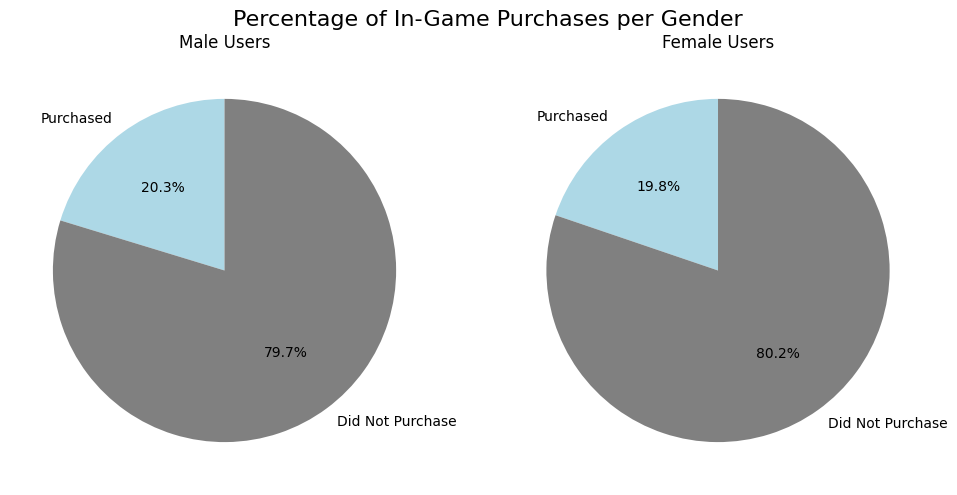

In [0]:
values = df['Gender'].value_counts()
total_males = values["Male"]
total_females = values["Female"]
purchase_counts = counts[1]
males = purchase_counts["Male"]
females =  purchase_counts["Female"]

male_pct = males / total_males * 100
female_pct = females / total_females * 100

sizes = [male_pct, 100-male_pct]
labels = ['Purchased', 'Did Not Purchase']

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.pie([males, total_males-males], labels=['Purchased','Did Not Purchase'],
        autopct='%1.1f%%', colors=['LightBlue','Gray'], startangle=90)
plt.title('Male Users')

plt.subplot(1,2,2)
plt.pie([females, total_females-females], labels=['Purchased','Did Not Purchase'],
        autopct='%1.1f%%', colors=['LightBlue','Gray'], startangle=90)
plt.title('Female Users')

plt.suptitle('Percentage of In-Game Purchases per Gender', fontsize=16)
plt.tight_layout()
plt.show()



# Although to their respective percent, around 20% of males and females do in game purchases.

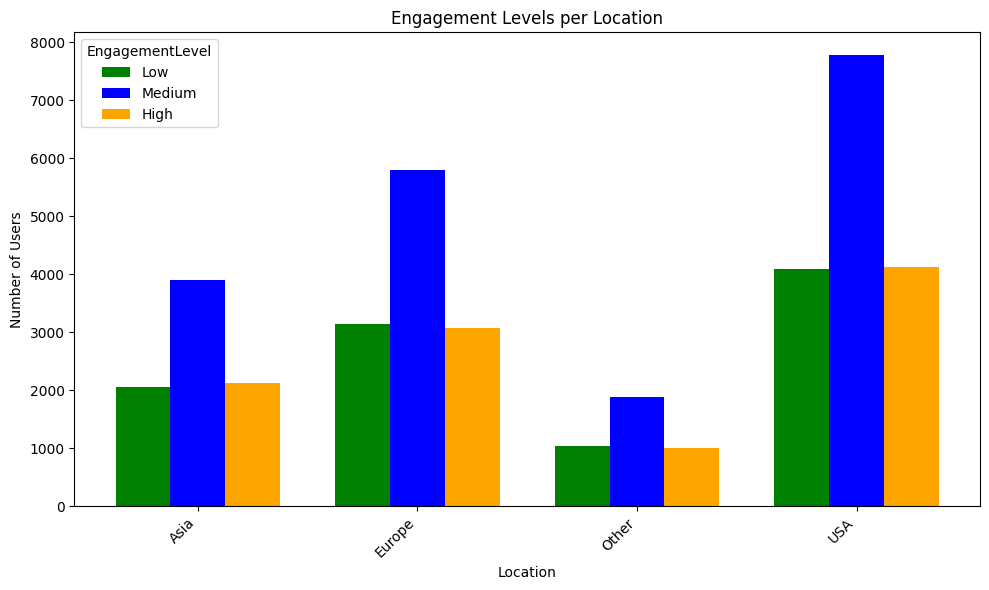

In [0]:
import matplotlib.pyplot as plt
import numpy as np


counts = df.groupby(['Location', 'EngagementLevel']).size().unstack(fill_value=0)
level_order = ['Low', 'Medium', 'High']
counts = counts[level_order]
x = np.arange(len(counts))
width = 0.25
fig, ax = plt.subplots(figsize=(10,6))

for i, level in enumerate(level_order):
    ax.bar(x + i*width, counts[level], width, label=level, color={'Low':'green','Medium':'blue','High':'orange'}[level])


ax.set_xlabel('Location')
ax.set_ylabel('Number of Users')
ax.set_title('Engagement Levels per Location')
ax.set_xticks(x + width)
ax.set_xticklabels(counts.index, rotation=45, ha='right')
ax.legend(title='EngagementLevel')

plt.tight_layout()
plt.show()


# The High engagement level is mostly prominent in the USA, while having the most players as well. Europe and Asia following with lower percentages of players. These two regions can get more marketing and advertising towards them, helping the game develop there.

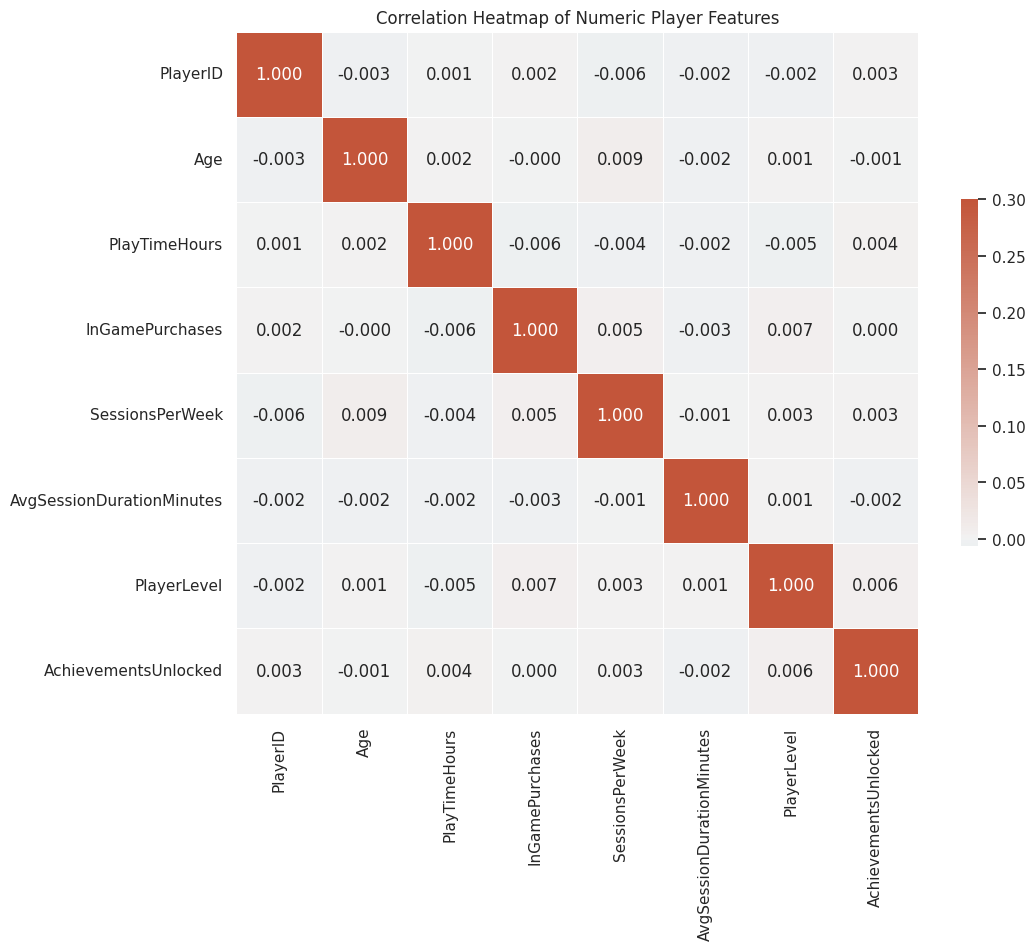

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme(style="white")
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".3f")
plt.title("Correlation Heatmap of Numeric Player Features")
plt.show()

## There is no linear correlation between the features.

# 3. Feature Engineering  

* Mapping Gender to binary values.
* Mapping GameDifficulty values to 0 - 1 - 2. 
* Mapping EngagementLevel values to 0 - 1 - 2. 
* One-Hot encoding Location and GameGenre.
* Dropping Player ID since it cannot help to predict EngagementLevel.

In [0]:
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

difficulty_map = {'Easy': 0, 'Medium': 1, 'Hard': 2}
df['GameDifficulty'] = df['GameDifficulty'].map(difficulty_map)

engagement_map = {'Low': 0, 'Medium': 1, 'High': 2}
df['EngagementLevel'] = df['EngagementLevel'].map(engagement_map)

df = pd.get_dummies(df, columns=['Location', 'GameGenre'], drop_first=False)

print(df.head())
print(df.dtypes)

   PlayerID  Age  ...  GameGenre_Sports  GameGenre_Strategy
0      9000   43  ...                 0                   1
1      9001   29  ...                 0                   1
2      9002   22  ...                 1                   0
3      9003   35  ...                 0                   0
4      9004   33  ...                 0                   0

[5 rows x 20 columns]
PlayerID                       int64
Age                            int64
Gender                         int64
PlayTimeHours                float64
InGamePurchases                int64
GameDifficulty                 int64
SessionsPerWeek                int64
AvgSessionDurationMinutes      int64
PlayerLevel                    int64
AchievementsUnlocked           int64
EngagementLevel                int64
Location_Asia                  uint8
Location_Europe                uint8
Location_Other                 uint8
Location_USA                   uint8
GameGenre_Action               uint8
GameGenre_RPG            

In [0]:
df = df.drop("PlayerID", axis=1)


In [0]:
y = df["EngagementLevel"]
df = df.drop("EngagementLevel", axis=1)


#Model Training & Evaluation (with MLflow tracking)  

* Training XGBoost classifier on the training set while performing Grid Search for: 1) **Max Depth**, 2) **Learning Rate**, 3) **Subsample**, 4) **Colsample Bytree**, 5) **N-Estimators**.
* Tracking all experiments with MlFlow on Databricks

In [0]:
import mlflow
import mlflow.xgboost
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import io
from itertools import product
import time

mlflow.set_registry_uri("databricks")

X_train, X_test, y_train, y_test = train_test_split(
    df, y, test_size=0.2, random_state=42, stratify=y
)


param_grid = {
    "max_depth": [6, 8, 10, 12],
    "learning_rate": [0.03, 0.05, 0.07],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.8, 0.9, 1.0],
    "n_estimators": [200, 300, 400, 500],

}

param_combinations = list(product(
    param_grid["max_depth"],
    param_grid["learning_rate"],
    param_grid["subsample"],
    param_grid["colsample_bytree"],
    param_grid["n_estimators"]
))

best_auc = 0
best_params = None

for (
    max_depth,
    learning_rate,
    subsample,
    colsample_bytree,
    n_estimators,
) in param_combinations:

    run_name = (
        f"xgb_md{max_depth}_lr{learning_rate}_ne{n_estimators}"
    )

    with mlflow.start_run(run_name=run_name):
        mlflow.xgboost.autolog(log_models=False)

        # Track hyperparameters
        mlflow.log_params({
            "max_depth": max_depth,
            "learning_rate": learning_rate,
            "subsample": subsample,
            "colsample_bytree": colsample_bytree,
            "n_estimators": n_estimators,
        })

        # Initialize model
        xgb = XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            random_state=42,
            use_label_encoder=False,
            eval_metric="mlogloss",
            tree_method="hist",  
        )

        # Fit with timing 
        start_time = time.time()
        xgb.fit(
            X_train, y_train,
            verbose=False
        )
        duration = time.time() - start_time
        mlflow.log_metric("train_time_sec", duration)

        # Evaluate 
        y_pred = xgb.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        report_dict = classification_report(y_test, y_pred, output_dict=True)

        mlflow.log_metric("accuracy", acc)
        if "weighted avg" in report_dict:
            mlflow.log_metric("precision_weighted", report_dict["weighted avg"]["precision"])
            mlflow.log_metric("recall_weighted", report_dict["weighted avg"]["recall"])
            mlflow.log_metric("f1_weighted", report_dict["weighted avg"]["f1-score"])

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        fig, ax = plt.subplots(figsize=(6, 5))
        sns.heatmap(
            cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test)
        )
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix (depth={max_depth}, lr={learning_rate})")
        mlflow.log_figure(fig, "confusion_matrix.png")
        plt.close(fig)

        # Feature Importance 
        importances = pd.Series(xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)
        fig2, ax2 = plt.subplots(figsize=(10, 6))
        sns.barplot(x=importances.values, y=importances.index, palette="viridis")
        plt.title("Feature Importance - XGBoost")
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.tight_layout()
        mlflow.log_figure(fig2, "feature_importance.png")
        plt.close(fig2)

        # Log model artifact
        mlflow.xgboost.log_model(xgb, artifact_path="xgboost_model")

        #  Track Best F1 
        f1_weighted = report_dict.get("weighted avg", {}).get("f1-score", 0)
        if f1_weighted > best_auc:
            best_auc = f1_weighted
            best_params = {
                "max_depth": max_depth,
                "learning_rate": learning_rate,
                "subsample": subsample,
                "colsample_bytree": colsample_bytree,
                "n_estimators": n_estimators
            }

print("Grid search complete.")
print(f"Best Weighted F1 = {best_auc:.4f}")
print(f"Best Params = {best_params}")

2025/10/15 15:06:58 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.
/local_disk0/.ephemeral_nfs/envs/pythonEnv-7a4dddb1-39f8-40de-a970-949e7fa6cb05/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [15:06:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
2025/10/15 15:07:01 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/databricks/python/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem

Grid search complete.
Best Weighted F1 = 0.9227
Best Params = {'max_depth': 12, 'learning_rate': 0.03, 'subsample': 0.7, 'colsample_bytree': 1.0, 'n_estimators': 200}


# Running the best model once again to get results and importance per feature.

* Best Params = {'max_depth': 12, 'learning_rate': 0.03, 'subsample': 0.7, 'colsample_bytree': 1.0, 'n_estimators': 200}

/local_disk0/.ephemeral_nfs/envs/pythonEnv-180cd4b0-6d7f-46cc-9c51-e1be08405c97/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:45:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


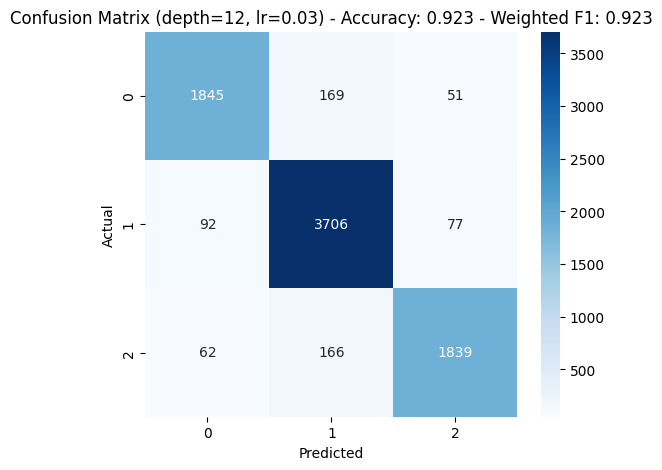

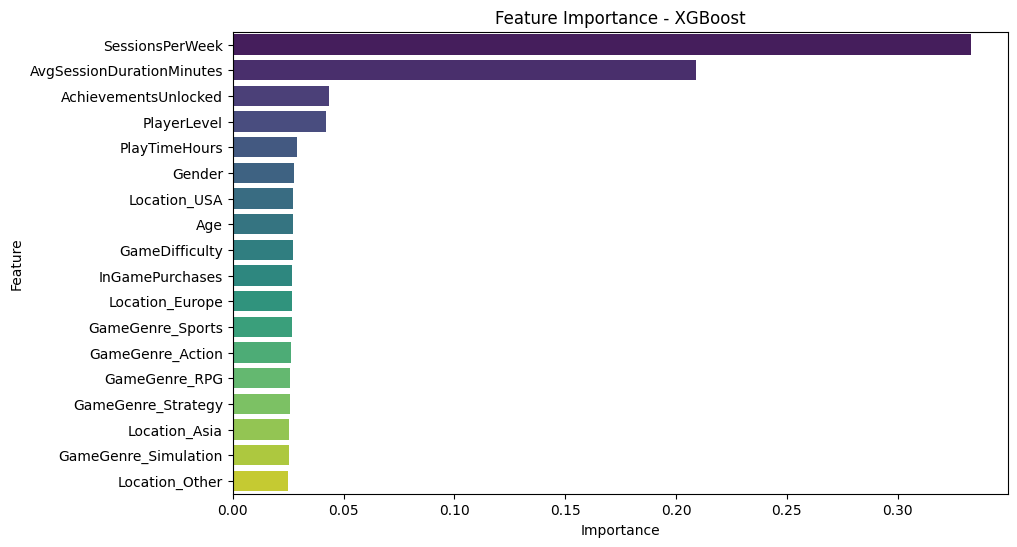

In [0]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


X_train, X_test, y_train, y_test = train_test_split(
    df, y, test_size=0.2, random_state=42, stratify=y
)
xgb = XGBClassifier(
            n_estimators=200,
            max_depth=12,
            learning_rate=0.03,
            subsample=0.7,
            colsample_bytree=1.0,
            random_state=42,
            use_label_encoder=False,
            eval_metric="mlogloss",
            tree_method="hist",  # faster
        )

xgb.fit(X_train, y_train,verbose=False)
y_pred = xgb.predict(X_test)
acc = accuracy_score(y_test, y_pred)
weighted_f1 = f1_score(y_test, y_pred, average='weighted')


cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(
            cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test)
    )
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (depth=12, lr=0.03) - Accuracy: {acc:.3f} - Weighted F1: {weighted_f1:.3f}")
plt.show()

importances = pd.Series(xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)
fig2, ax2 = plt.subplots(figsize=(10, 6))
sns.barplot(x=importances.values, y=importances.index, palette="viridis")
plt.title("Feature Importance - XGBoost")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


* The model achieves 92.3% accuracy while having a Weighted F1-Score of 92.27%.
* From the analysis the most important feature is by far the SessionsPerWeek with AvgSessionsDuration coming second.


# 5. Insights, Conclusions and Suggestions

## Key Insights
1. **Engagement vs. Sessions per Week:**  
   Players with more frequent weekly sessions demonstrate significantly higher engagement levels, making this the strongest indicator of overall player retention.

2. **Playtime Behavior:**  
   Interestingly, players in the *Medium* engagement category tend to spend the most hours per session. This suggests that session frequency, rather than session length, has a greater impact on maintaining high engagement.

3. **Game Difficulty:**  
   Engagement is fairly consistent across all difficulty levels, with *Easy* games being the most commonly played across all engagement categories. This implies that accessibility may contribute to sustaining engagement.

4. **In-Game Purchases and Gender:**  
   Both male and female players make in-game purchases at roughly similar proportions (~20%). However, since males dominate the player base, the overall purchase volume is higher among them.

5. **Geographic Distribution:**  
   The highest concentration of highly engaged players comes from the **USA**, followed by Europe and Asia. Expanding marketing and community engagement efforts in Europe and Asia could improve overall engagement globally.

6. **Feature Importance (Model Results):**  
   The **XGBoost model** achieved an **accuracy of 92.3%** and a **weighted F1-score of 92.27%**.  
   - **SessionsPerWeek** is by far the most influential feature in predicting engagement.  
   - **Average Session Duration** and **Player Level** follow as the next two predictors.  

---

## Conclusions 
- Player engagement is driven primarily by **habitual play frequency** rather than one-off long sessions or in-game spending.  
- To get higher engagement, the company should focus on **encouraging consistent play**, such as through daily rewards, session streaks, or short event cycles.  
- **Regional targeting** (Europe and Asia) and **balanced difficulty options** can help retain broader player demographics.  


---

## Suggestions
## 1. Strengthen Player Retention Through Habit Formation  
- Focus on **increasing the frequency of play sessions** rather than extending session duration.  
- Introduce **daily login rewards**, **weekly challenges**, and **streak-based bonuses** to encourage consistent activity.  

## 2. Optimize Game Difficulty and Progression  
- Since most players prefer *Easy* or *Medium* difficulties, maintain accessible entry points but add **progressive challenges** for advanced players.  

## 3. Expand Regional Marketing and Localization  
- The **USA** currently dominates high engagement levels, while **Europe and Asia** show strong potential.  
- Invest in **localized marketing campaigns**, language options, and culturally relevant content to boost engagement in these underperforming regions.  



